In [1]:
# Menginstal package kaggle
!pip install -q kaggle

In [2]:
from google.colab import files

# Mengupload file json dari profile kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akbartolandy","key":"52c6001a3de19543a368743e284fa79b"}'}

In [3]:
# Membuat direktory dan mengubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d kadenswarr/hourly-weather-data-in-denver

  0% 0.00/1.47M [00:00<?, ?B/s]
100% 1.47M/1.47M [00:00<00:00, 48.1MB/s]


In [5]:
# Ekstrak file zip dan melihat isi dataset
!mkdir hourly-weather-data-in-denver
!unzip hourly-weather-data-in-denver.zip -d hourly-weather-data-in-denver
!ls hourly-weather-data-in-denver

Archive:  hourly-weather-data-in-denver.zip
  inflating: hourly-weather-data-in-denver/weather_data_long.csv  
weather_data_long.csv


In [6]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
data_train = pd.read_csv('hourly-weather-data-in-denver/weather_data_long.csv')
data_train.head()

,Date,Time,Temperature,DewPoint,Humidity,Wind,WinSpeed,WindGust,Pressure,Precip.,Condition
0,2002-01-01,12:53 AM,19,13,77,ENE,14,0,24.73,0.0,Cloudy
1,2002-01-02,12:53 AM,10,-3,56,SE,5,0,24.94,0.0,Mostly Cloudy
2,2002-01-04,12:53 AM,30,14,51,W,9,0,24.45,0.0,Partly Cloudy
3,2002-01-05,12:53 AM,25,18,75,CALM,0,0,24.74,0.0,Mostly Cloudy
4,2002-01-06,12:53 AM,23,9,55,SSE,13,0,24.74,0.0,Mostly Cloudy


In [8]:
data_train.shape

(145233, 11)

In [9]:
# Mengecek apakah ada data yang null
data_train.isnull().sum()

Date             0
Time             0
Temperature      0
DewPoint         0
Humidity         0
Wind           197
WinSpeed         0
WindGust         0
Pressure         0
Precip.          0
Condition        4
dtype: int64

In [10]:
# Memilih kolom yang akan digunakan
df = data_train.iloc[100000:145233][['Date', 'Temperature']]

Text(0.5, 1.0, 'Temperature average')

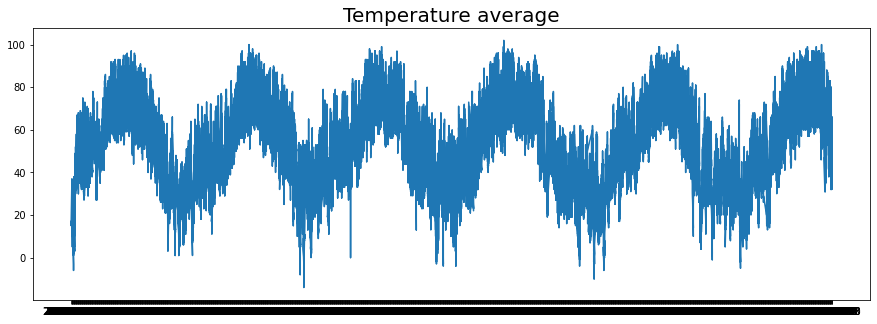

In [21]:
dates = df['Date'].values
temp = df['Temperature'].astype('float').values

# Membuat plot data
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=20)

In [22]:
from sklearn.model_selection import train_test_split

# Membagi dataset menjadi train dan test
X_train, X_test, Y_train, Y_test = train_test_split(temp, dates, test_size=0.2, shuffle=False)

print(len(X_train), len(X_test))

36186 9047


In [23]:
min_mae = (temp.max() - temp.min()) * 0.1
print(min_mae)

11.600000000000001


In [24]:
# merubah data menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [25]:
train_set = windowed_dataset(X_train, window_size=32, batch_size=64, shuffle_buffer=1000)
val_set = windowed_dataset(X_test, window_size=32, batch_size=64, shuffle_buffer=1000)

model = tf.keras.models.Sequential([                          
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),  
])

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [27]:
# Membuat custom callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < min_mae):
      print('\nMAE has reach < 10% from total data!')
      self.model.stop_training = True

cust_callbacks = myCallback()

In [28]:
from keras.callbacks import ReduceLROnPlateau

hist = model.fit(train_set, validation_data=val_set, 
                 epochs=100, callbacks=[cust_callbacks, ReduceLROnPlateau()])

Epoch 1/100
565/565 [==============================] - 32s 49ms/step - loss: 31.9824 - mae: 32.4787 - val_loss: 19.9816 - val_mae: 20.4780
Epoch 2/100
565/565 [==============================] - 27s 47ms/step - loss: 7.2961 - mae: 7.7819 - val_loss: 6.0067 - val_mae: 6.4904

MAE has reach < 10% from total data!


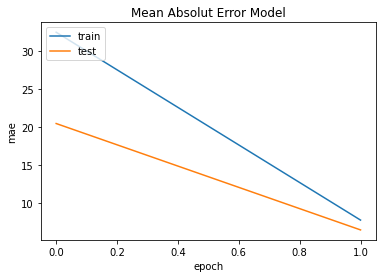

In [29]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Mean Absolut Error Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

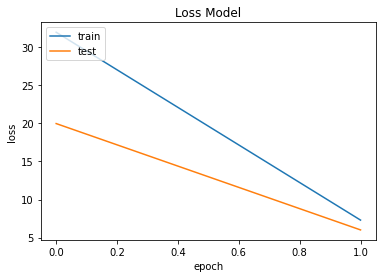

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()